In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from models import *
from ucr import *
from inception import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [4]:
DATAPATH.ls()

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/PowerCons'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/PhalangesOutlinesCorrect'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Herring'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ElectricDevices'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Plane'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/DataSummaryExpanded_v03.xlsx'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/MiddlePhalanxTW'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ECG5000'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CricketZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/WormsTwoClass'),
 PosixPath('/home/tc256760/Documents/Time

In [5]:
task = 'Adiac'
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac


In [6]:
num_classes = df_train.target.nunique(); num_classes

37

# DL

In [7]:
X_train, y_train, X_test, y_test = process_dfs(df_train, df_test, True); X_train.shape

(390, 1, 176)

In [8]:
X_train = torch.Tensor(X_train).float().cuda()
y_train = torch.Tensor(y_train).long().cuda()

X_test = torch.Tensor(X_test).float().cuda()
y_test = torch.Tensor(y_test).long().cuda()

no_samples = X_train.shape[0]


## Resnet 1D

In [9]:
# model = create_resnet(1, num_classes, conv_sizes=[64, 128, 256], stride=1).cuda()

In [10]:
model = create_inception(1, num_classes).cuda()

In [11]:
# model = create_mlp(X_train[0].shape[-1], num_classes).cuda()

In [12]:
# model = create_fcn(1, num_classes)

In [13]:
model = model.cuda()

## LBFGS

In [14]:
from lbfgs import *
from fastprogress import progress_bar

In [15]:
from torch.autograd import Variable
def get_grad(optimizer, X, y, opfun, loss_fn):

    optimizer.zero_grad()
    ops = opfun(X)

    # define loss and perform forward-backward pass
    loss = loss_fn(ops, y)
    loss.backward()

    # gather flat gradient
    grad = optimizer._gather_flat_grad()

    return grad, loss

In [16]:
optimizer = LBFGS(model.parameters(), lr=1e-1, history_size=10, line_search='Wolfe', debug=True)
loss_fn = CrossEntropyFlat()

In [17]:
X_train.shape, y_train.shape, y_train.dtype

(torch.Size([390, 1, 176]), torch.Size([390]), torch.int64)

In [18]:
# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: accuracy(op, y)
opfun = lambda X: model(X)

In [19]:
def stats(model,X_test, y_test):
    y_pred_test = model(X_test)
    return error_rate(y_pred_test, y_test).data.item()

In [20]:
# main loop
max_iter=100

grad, obj = get_grad(optimizer, X_train, y_train, opfun, loss_fn)
for n_iter in progress_bar(range(max_iter)):

    # training mode
    model.train()
    
    p = optimizer.two_loop_recursion(-grad)   
    # define closure for line search
    def closure():
        optimizer.zero_grad()
        y_pred = model(X_train) 
        loss = loss_fn(y_pred, y_train)
        return loss

    # perform line search step
    if n_iter==0: options = {'closure': closure}#, 'current_loss': obj}
    else:  {'closure': closure, 'current_loss': obj}
    obj, grad, lr, _, _, _, _, _  = optimizer.step(p, grad, options=options)
    
    optimizer.curvature_update(grad)

    model.eval()

    print(f'{n_iter} - train_loss: {obj.data.item()}, error_rate: {stats(model, X_test, y_test)}, lr: {lr}')

0 - train_loss: 4.199389457702637, error_rate: 0.9693094491958618, lr: 0.024545247635888046
1 - train_loss: 3.9713547229766846, error_rate: 0.9693094491958618, lr: 0.1
2 - train_loss: 3.9018852710723877, error_rate: 0.9693094491958618, lr: 0.2
3 - train_loss: 3.8374781608581543, error_rate: 0.9693094491958618, lr: 0.1
4 - train_loss: 3.779695749282837, error_rate: 0.9693094491958618, lr: 0.1
5 - train_loss: 3.723454475402832, error_rate: 0.9693094491958618, lr: 0.1
6 - train_loss: 3.676482915878296, error_rate: 0.9693094491958618, lr: 0.1
7 - train_loss: 3.635984182357788, error_rate: 0.9693094491958618, lr: 0.1
8 - train_loss: 3.5889883041381836, error_rate: 0.9693094491958618, lr: 0.1
9 - train_loss: 3.539710760116577, error_rate: 0.9693094491958618, lr: 0.1
10 - train_loss: 3.5020363330841064, error_rate: 0.9693094491958618, lr: 0.1
11 - train_loss: 3.4677746295928955, error_rate: 0.9693094491958618, lr: 0.1
12 - train_loss: 3.426063060760498, error_rate: 0.9693094491958618, lr: 0.1

## Eval

In [59]:
model.eval()
p = model(X_test)

In [60]:
error_rate(p, y_test)

tensor(0.2660, device='cuda:0')

In [61]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

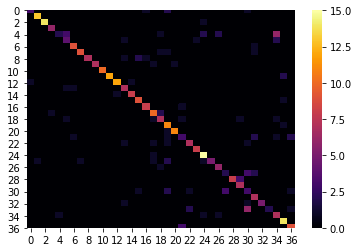

In [62]:
sns.heatmap(get_cm(p,y_test), cmap='inferno')